In [22]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

# Define Data Paths 
base_dir = r"/Users/charinduliyanage17/Documents/GitHub/Research_Test/Dataset/" 

# Check if base directory exists
if not os.path.exists(base_dir):
    print(f"Error: Base directory does not exist: {base_dir}")
else:
    print(f"Base directory found: {base_dir}")
    print("Contents:", os.listdir(base_dir))

train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')

# Verify subdirectories exist
print(f"\nTrain directory: {train_dir}")
print(f"Train directory exists: {os.path.exists(train_dir)}")
if os.path.exists(train_dir):
    print("Train subdirectories:", os.listdir(train_dir))

print(f"\nVal directory: {val_dir}")
print(f"Val directory exists: {os.path.exists(val_dir)}")
if os.path.exists(val_dir):
    print("Val subdirectories:", os.listdir(val_dir))

#  Set Up Model Parameters
IMG_SIZE = (224, 224) # MobileNetV2 was trained on 224x224 images
BATCH_SIZE = 32       # How many images to process at once

# Load the Eye Data
# automatically find class folders (e.g., 'Open_Eyes', 'Closed_Eyes', ...)

try:
    print("\nLoading training data...")
    train_eye_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=123 
    )
    # Expose class names and number of classes
    class_names = train_eye_dataset.class_names
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")
except Exception as e:
    print(f"Error loading training data: {e}")
    class_names = None
    num_classes = None

try:
    print("Loading validation data...")
    val_eye_dataset = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        label_mode='categorical',
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        seed=123
    )
except Exception as e:
    print(f"Error loading validation data: {e}")

#  Optimize Data Loading 
AUTOTUNE = tf.data.AUTOTUNE

try:
    train_eye_dataset = train_eye_dataset.prefetch(buffer_size=AUTOTUNE)
    val_eye_dataset = val_eye_dataset.prefetch(buffer_size=AUTOTUNE)
    print("\n Data loading setup is complete.")
except Exception as e:
    print(f"Could not optimize data loading: {e}")


Loading training data...
Found 8548 files belonging to 4 classes.
Loading validation data...
Found 1554 files belonging to 4 classes.
Loading validation data...
Found 1554 files belonging to 4 classes.


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Create a Data Augmentation Layer 
data_augmentation = models.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

#  Load the Pre-trained Base Model (MobileNetV2)

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,), 
    include_top=False, 
    weights='imagenet'
)

#  Freeze the Base Model 

base_model.trainable = False

# Add Own Classification "Head"

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

# Apply data augmentation
x = data_augmentation(inputs)

# Pre-process the inputs (scales pixel values from [0, 255] to [-1, 1])
# This is how MobileNetV2 expects its data.
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# Pass the data to the frozen base_model
x = base_model(x, training=False) # 'training=False' is important here

# flatten the output from the base model
x = layers.GlobalAveragePooling2D()(x)

# Add a "dropout" layer to prevent overfitting
x = layers.Dropout(0.2)(x)

# Add final output layer.
if num_classes is None:
    # fallback to 2 classes (binary) if num_classes couldn't be determined
    num_classes = 2

outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create and Compile the Final Model

eye_model = models.Model(inputs, outputs)

# Now we compile the model
eye_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy' if num_classes and num_classes > 2 else 'binary_crossentropy', 
    metrics=['accuracy'] 
)

#  Print a Summary

eye_model.summary()

print("\n Eye-State Detector model is built, compiled, and ready for training.")

Starting training for 10 epochs...
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.7918 - loss: 0.5395 - val_accuracy: 0.9691 - val_loss: 0.0930
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.7918 - loss: 0.5395 - val_accuracy: 0.9691 - val_loss: 0.0930
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9657 - loss: 0.1151 - val_accuracy: 0.9640 - val_loss: 0.0959
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9657 - loss: 0.1151 - val_accuracy: 0.9640 - val_loss: 0.0959
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step - accuracy: 0.9706 - loss: 0.0967 - val_accuracy: 0.9736 - val_loss: 0.0743
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 159ms/step - accuracy: 0.9706 - loss: 0.0967 - val_accuracy: 0.9736 - val_loss: 0.0743
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.9740 - loss: 0.0865 - val_accuracy: 0.9788 - val_loss: 0.0607
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 44s 163m

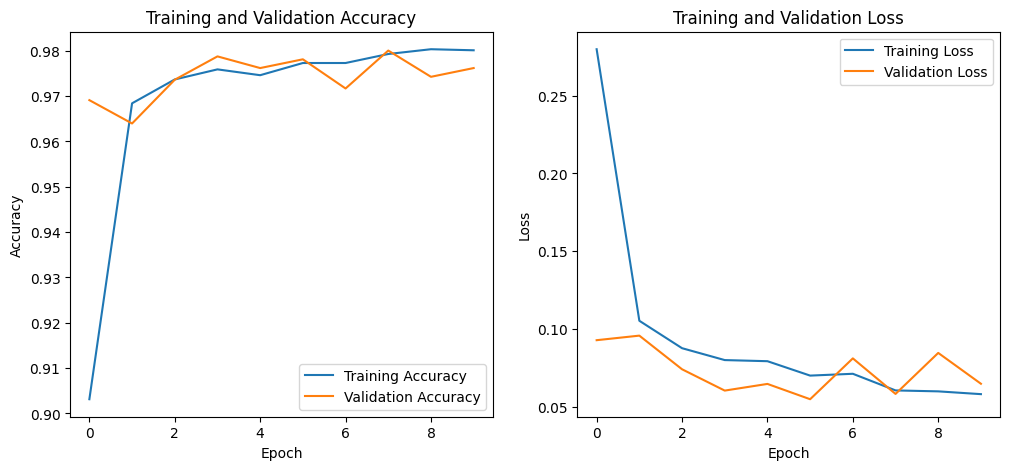

In [19]:
# Set Training Parameters 

EPOCHS = 10

#  Train the Model 

print(f"Starting training for {EPOCHS} epochs...")

history = eye_model.fit(
    train_eye_dataset,
    epochs=EPOCHS,
    validation_data=val_eye_dataset
)

print("\n Training complete!")

#  Plot the Results (Accuracy and Loss)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.show()

Generating predictions for test set...
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step

Class names: ['Closed_Eyes', 'No_yawn', 'Open_Eyes', 'Yawn']

Class names: ['Closed_Eyes', 'No_yawn', 'Open_Eyes', 'Yawn']


2025-11-14 18:25:09.790880: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


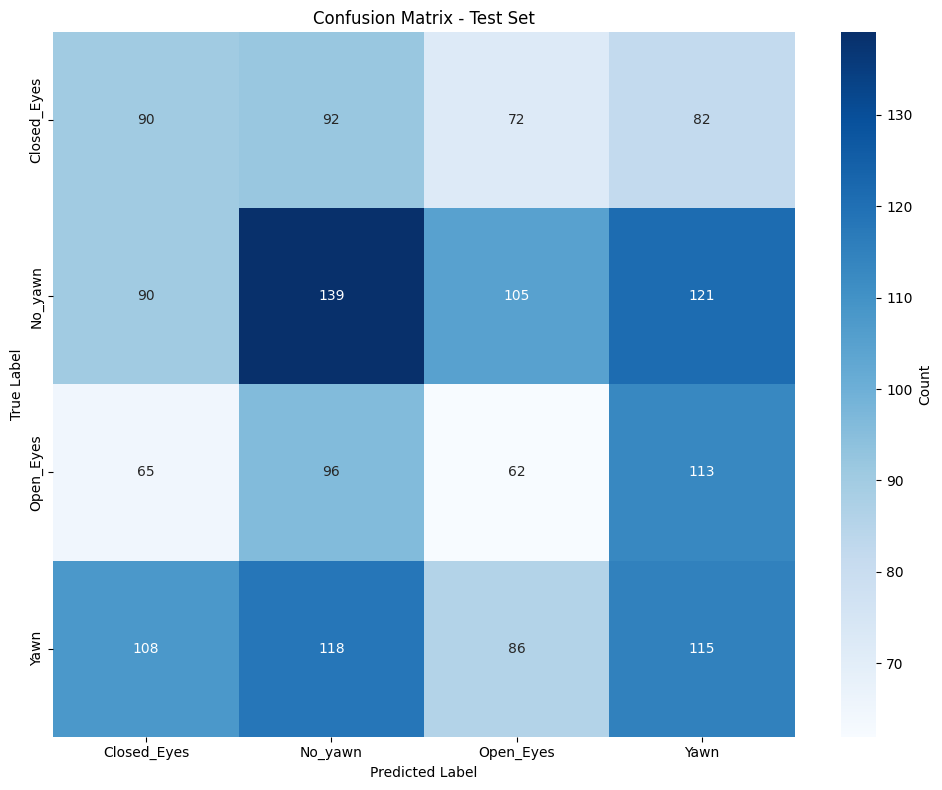


Classification Report:
              precision    recall  f1-score   support

 Closed_Eyes       0.25      0.27      0.26       336
     No_yawn       0.31      0.31      0.31       455
   Open_Eyes       0.19      0.18      0.19       336
        Yawn       0.27      0.27      0.27       427

    accuracy                           0.26      1554
   macro avg       0.26      0.26      0.26      1554
weighted avg       0.26      0.26      0.26      1554



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on the test set
print("Generating predictions for test set...")
y_pred_probs = eye_model.predict(val_eye_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from validation dataset
y_true = []
for images, labels in val_eye_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = val_eye_dataset.class_names
print("\nClass names:", class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))